# Uplift Modeling on Simulated Education Dataset

In this notebook, we train causal uplift models to estimate the **Individual Treatment Effect (ITE)** of **private tutoring** on students' academic performance.

We use the synthetic dataset generated in `01_simulate_data.ipynb`, which contains:

- Confounding variables (motivation, GPA, engagement)
- True counterfactual outcomes (`y0`, `y1`)
- Observed outcome based on treatment

We will train the following models:

- T-Learner
- X-Learner
- Causal Forest

And evaluate them using:

- **Mean Squared Error (MSE)** on uplift
- **Qini curves and AUUC**
- Visualisations and segment analysis

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklift.metrics import qini_curve, qini_auc_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from econml.metalearners import TLearner, XLearner
from causalml.metrics import qini_score
from econml.dml import CausalForestDML

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Overview and Exploration
Some exploratory analysis of :
1. GPA Distribution
2. Study Hours
3. Treatment vs Control group count

In [4]:
# Load data
df = pd.read_csv("../data/synthetic_education_uplift.csv")

print("Dataset Preview:")
display(df.head())
print("\nSummary Statistics:")
display(df.describe())

Dataset Preview:


,motivation,engagement,prior_gpa,age,study_hours,treatment,y0,y1,outcome,uplift
0,0.496714,1,3.005176,18,1.884987,0,1.857291,2.257291,1.857291,0.4
1,-0.138264,0,2.150100,19,0.681881,0,0.992129,0.992129,0.992129,0.0
2,0.647689,1,3.344907,21,4.002895,0,2.528694,2.928694,2.528694,0.4
3,1.523030,1,2.944850,19,4.451074,0,2.758270,3.158270,2.758270,0.4
4,-0.234153,1,2.849402,24,3.411012,0,2.067790,2.467790,2.067790,0.4



Summary Statistics:


,motivation,engagement,prior_gpa,age,study_hours,treatment,y0,y1,outcome,uplift
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.002136,0.499100,2.746438,21.003200,2.755500,0.102900,1.925141,2.134891,1.935881,0.209750
std,1.003462,0.500024,0.552844,2.008182,1.225842,0.303843,0.633918,0.806966,0.642175,0.216709
min,-3.922400,0.000000,0.965006,18.000000,0.000000,0.000000,-0.047623,-0.047623,-0.047623,0.000000
25%,-0.672591,0.000000,2.344376,19.000000,1.891774,0.000000,1.452430,1.472467,1.455152,0.000000
50%,-0.002595,0.000000,2.739320,21.000000,2.739158,0.000000,1.918777,2.120632,1.927632,0.000000
75%,0.671081,1.000000,3.156399,23.000000,3.614769,0.000000,2.400041,2.782055,2.421709,0.400000
max,3.926238,1.000000,4.000000,24.000000,7.798858,1.000000,3.921692,4.621692,4.037540,0.700000


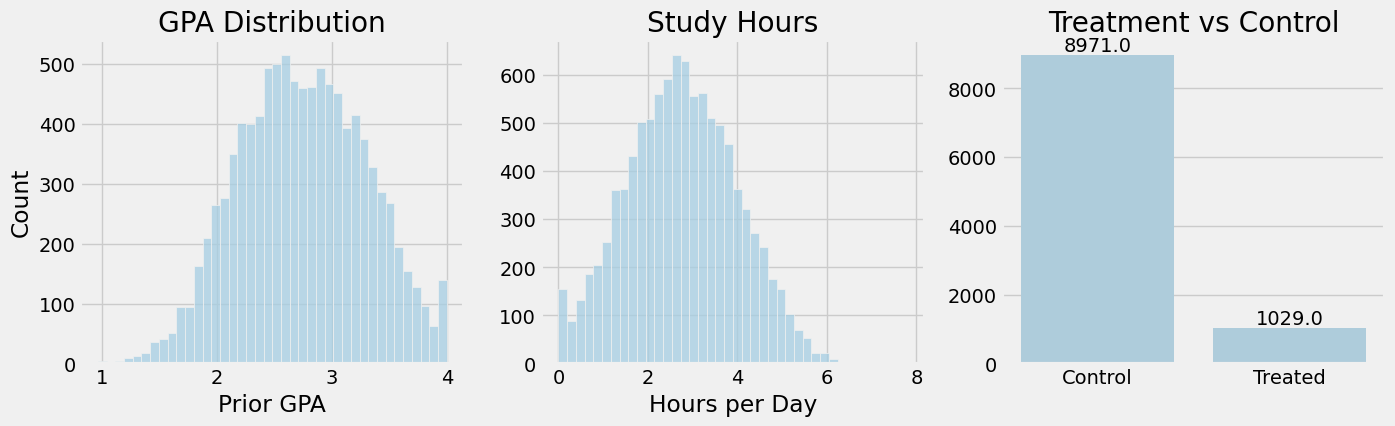

In [3]:
fig, axes = plt.subplots(1,3, figsize=(15,4))

# GPA
sns.histplot(df['prior_gpa'], bins=40, ax=axes[0])
axes[0].set_title("GPA Distribution")
axes[0].set_xlabel("Prior GPA")
axes[0].set_ylabel("Count")

# Study Hours
sns.histplot(df['study_hours'], bins=40, ax=axes[1])
axes[1].set_title("Study Hours")
axes[1].set_xlabel("Hours per Day")
axes[1].set_ylabel("")

# Treatment vs Control
sns.countplot(x='treatment', data=df, ax=axes[2])
axes[2].set_title("Treatment vs Control")
axes[2].set_xticks([0,1])
axes[2].set_xticklabels(['Control','Treated'])
axes[2].set_xlabel("")
axes[2].set_ylabel("")
for p in axes[2].patches:
    height = p.get_height()
    axes[2].annotate(f"{height}", (p.get_x()+p.get_width()/2, height),
                     ha='center', va='bottom')

## Train-Test Split

In [7]:
# Binarise outcome: 1 if outcome improved, 0 if not
df['binary_outcome'] = (df['outcome'] > df['prior_gpa']).astype(int)

features = ['motivation', 'engagement', 'prior_gpa', 'age', 'study_hours']
X = df[features]
T = df['treatment']
y = df['binary_outcome']    
y_true_ite = df['uplift']

X_train, X_test, T_train, T_test, y_train, y_test, uplift_train, uplift_test = train_test_split(
    X, T, y, y_true_ite, test_size=0.3, random_state=42
)


## Propensity Score Estimation

In real causal modeling, we estimate how likely each subject is to receive treatment (`propensity score`).

Here we use logistic regression to estimate:
$$
e(X) = P\bigl(T = 1 \mid X\bigr)
$$

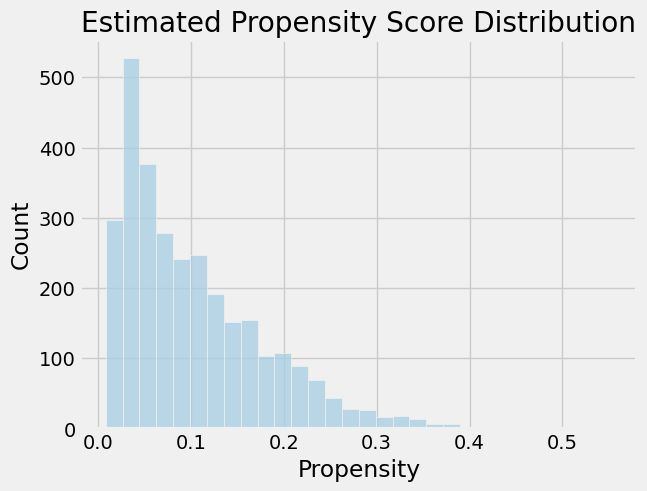

In [8]:
prop_model = LogisticRegression()
prop_model.fit(X_train, T_train)

# Propensity score estimate
e_hat = prop_model.predict_proba(X_test)[:, 1]

sns.histplot(e_hat, bins=30)
plt.title("Estimated Propensity Score Distribution")
plt.xlabel("Propensity")
plt.show()

## Model Training & Evaluation

In this notebook we assess the effectiveness of 4 different models:
1. Baseline Uplift Model (Random Targeting)
2. T-Learner
3. X-Learner
4. Causal Forests

### 1. Baseline Uplift Model

Before fitting any causal models, we define a naïve baseline:

- **No uplift**: predict 0 uplift for everyone  
- **Random targeting**: shuffle predictions

Compute its MSE and Qini-AUC so we can compare all our models against “doing nothing.”

- **MSE (ITE)** measures how close the model's predicted uplift is to the *true* counterfactual uplift. Lower is better.
- **Qini AUC** evaluates how well the model ranks individuals by uplift. This is crucial for real-world decision targeting (e.g., who gets tuition).

Baseline MSE: 0.08939666666666661
Baseline Qini-AUC: 0.0


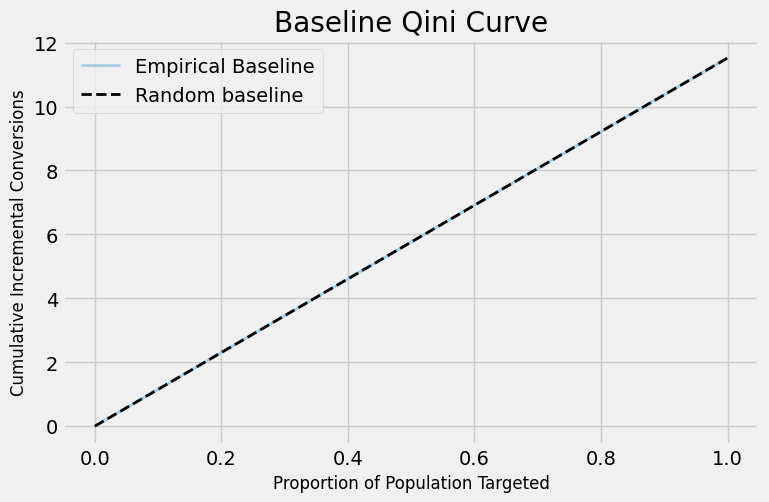

In [9]:
baseline_uplift = np.zeros_like(uplift_test)

# Calculate MSE
baseline_mse = mean_squared_error(uplift_test, baseline_uplift)
print("Baseline MSE:", baseline_mse)

# Calculate AUC score
baseline_qini = qini_auc_score(y_test, baseline_uplift, T_test)
print("Baseline Qini-AUC:", baseline_qini)

x_raw, gains = qini_curve(y_test, baseline_uplift, T_test)
n = len(y_test)
x_prop = x_raw / n

# Random baseline: diagonal to the last cumulative gain value
random_line = x_prop * gains[-1] / x_prop[-1]

plt.figure(figsize=(8, 5))
plt.plot(x_prop, gains, label="Empirical Baseline", linewidth=2)
plt.plot(x_prop, random_line, 'k--', label="Random baseline", linewidth=2)
plt.xlabel("Proportion of Population Targeted", fontsize=12)
plt.ylabel("Cumulative Incremental Conversions", fontsize=12)
plt.title("Baseline Qini Curve")
plt.legend()
plt.show()

### 2. T-Learner

We fit two separate models using regression techniques:
- One on treated subjects **$Y_1$**
- One on control subjects **$Y_0$**

Predicted ITE is:
$$
\hat{\tau}(x) = \hat{y}_1(x) - \hat{y}_0(x)
$$

T-Learner MSE on ITE: 0.0630
T-Learner Qini AUC: 0.5255


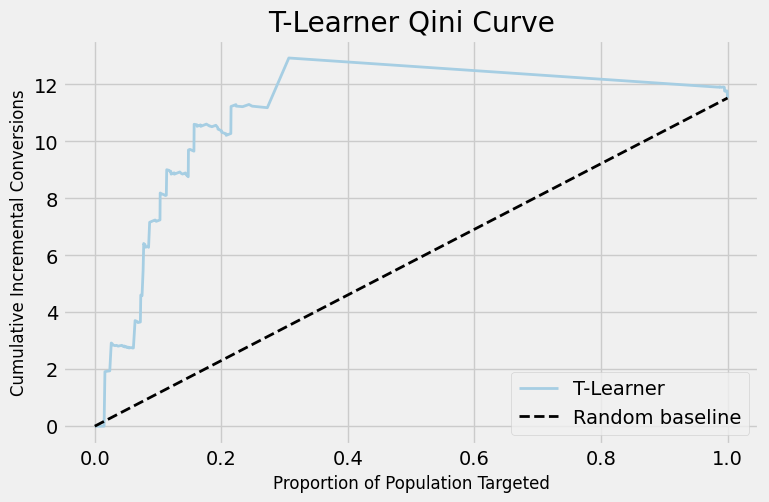

In [10]:
t_learner = TLearner(models=RandomForestRegressor())
t_learner.fit(y_train.values, T_train.values, X=X_train.values)

# Predict uplift
uplift_pred_t = t_learner.effect(X_test.values)

# Calculate MSE
mse_t = mean_squared_error(uplift_test, uplift_pred_t)
print(f"T-Learner MSE on ITE: {mse_t:.4f}")

# Calculate AUC score
qini_t = qini_auc_score(y_test, uplift_pred_t, T_test)
print(f"T-Learner Qini AUC: {qini_t:.4f}")

x_raw, gains = qini_curve(y_test, uplift_pred_t, T_test)
n = len(y_test)
x_prop = x_raw / n

# Random baseline: diagonal to the last cumulative gain value
random_line = x_prop * gains[-1] / x_prop[-1]

plt.figure(figsize=(8, 5))
plt.plot(x_prop, gains, label="T-Learner", linewidth=2)
plt.plot(x_prop, random_line, 'k--', label="Random baseline", linewidth=2)
plt.xlabel("Proportion of Population Targeted", fontsize=12)
plt.ylabel("Cumulative Incremental Conversions", fontsize=12)
plt.title("T-Learner Qini Curve")
plt.legend()
plt.show()

### 3. X-Learner
Just as in T-Learner, the treated and control groups are modelled using regressing techniques.\
This produces:
- $\hat{y}_1(x)$: the modelled outcomes of the treated group for all features X
- $\hat{y}_0(x)$: the modelled outcomes of the control group for all features X

This allows us to calculate pseudo outcomes for outcomes that were before unmeasurable, i.e. *"**treated outcomes for the control group** and **untreated outcomes for the treated.**"*

The pseudo outcomes are as follows:
- $\hat{D}_1 = Y - \hat{y}_1(x)$ for the treated group
- $\hat{D}_0 = \hat{y}_0(x) - Y$ for the control group

Now indetical to $\hat{y}_1(x)$ and $\hat{y}_0(x)$, we use the pseudo outcomes to model the treated and control groups' treatment effect.\
These are:
- $\hat{\tau}_1(x)$: new model of the treated group
- $\hat{\tau}_0(x)$: new model of the control group

To overcome any group imbalance, the models are combined with a propensity weighting. This is the final uplift model:
$$\hat{\tau}(x) = (1-e(x)) \cdot \hat{\tau}_1(x) + e(x) \cdot \hat{\tau}_0(x)

X-Learner MSE on ITE: 0.0590
X-Learner Qini AUC: 0.4961


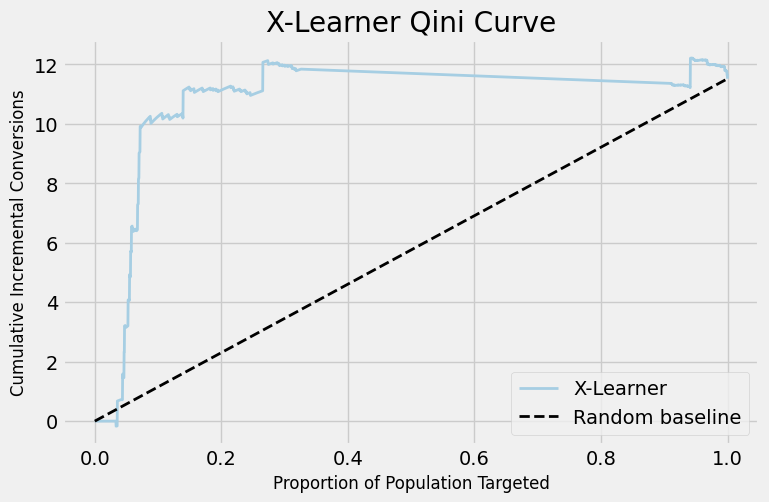

In [11]:
x_learner = XLearner(models=RandomForestRegressor())
x_learner.fit(y_train.values, T_train.values, X=X_train.values)

uplift_pred_x = x_learner.effect(X_test.values)

# Calculate MSE
mse_x = mean_squared_error(uplift_test, uplift_pred_x)
print(f"X-Learner MSE on ITE: {mse_x:.4f}")

# Calculate AUC score
qini_x = qini_auc_score(y_test, uplift_pred_x, T_test)
print(f"X-Learner Qini AUC: {qini_x:.4f}")

x_raw, gains = qini_curve(y_test, uplift_pred_x, T_test)
n = len(y_test)
x_prop = x_raw / n

# Random baseline: diagonal to the last cumulative gain value
random_line = x_prop * gains[-1] / x_prop[-1]

plt.figure(figsize=(8, 5))
plt.plot(x_prop, gains, label="X-Learner", linewidth=2)
plt.plot(x_prop, random_line, 'k--', label="Random baseline", linewidth=2)
plt.xlabel("Proportion of Population Targeted", fontsize=12)
plt.ylabel("Cumulative Incremental Conversions", fontsize=12)
plt.title("X-Learner Qini Curve")
plt.legend()
plt.show()

### 4. Causal Forest (CATE Estimation)

As in the previous modeling steps, we first model the observed outcomes and the propensity score:
- Outcome: $\hat{y}(x) = \mathbb{E}[Y \mid X = x]$ 
- Propensity: $\hat e(x) = \mathbb{P}(T = 1 \mid X = x)$

Next, we calculate **residuals** to eliminate any confounding from $X$. By subtracting the variation explained by $X$, any remaining residual variation must be uncorrelated with $X$ and instead, reflect the causal effect between $Y$ and $T$.
- $\displaystyle \tilde Y_i = Y_i - \hat{y}(X_i)$ 
- $\displaystyle \tilde T_i = T_i - \hat e(X_i)$  

We then **build an “honest” causal forest**, which works as described below.
   - **Honesty**: split data into two disjoint sets, one for choosing splits and the other for estimating leaf effects.
   - Splits are chosen to **maximise heterogeneity** in local treatment effects. 

Then, we must **estimate leaf‐level CATE** as follows.\
In each leaf $L$:  
   $$
     \hat\tau_L
     = \frac{1}{|L_1|}\sum_{i \in L_1} Y_i
     - \frac{1}{|L_0|}\sum_{i \in L_0} Y_i
   $$

Then we finally **aggregate across all trees** in the forest to obtain the overall CATE estimate at point $x$.
   $$
     \hat\tau(x)
     = \frac{1}{B}\sum_{b=1}^B \hat\tau^{(b)}(x)
   $$

X-Learner MSE on ITE: 0.0590
Causal Forest Qini AUC: 0.5207


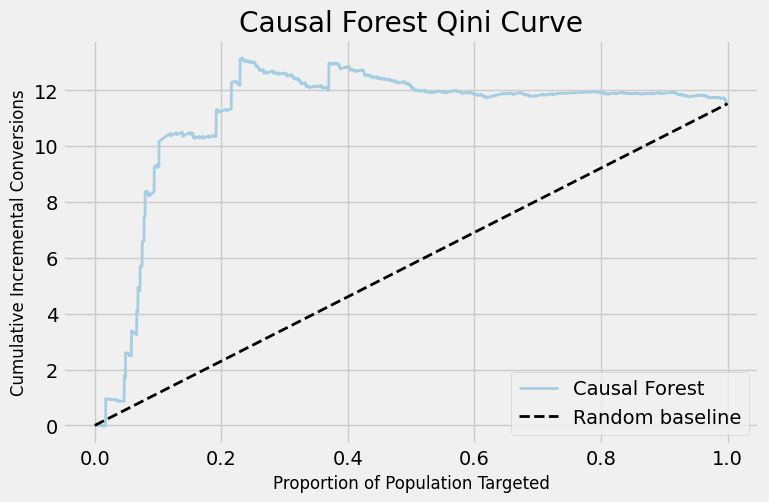

In [12]:
# Train causal forest
cf_model = CausalForestDML(
    model_t=RandomForestClassifier(),
    model_y=RandomForestRegressor(),
    discrete_treatment=True,
    n_estimators=200,
    min_samples_leaf=10,
    random_state=42
)
cf_model.fit(y_train.values, T_train.values, X=X_train.values)

uplift_pred_cf = cf_model.effect(X_test.values)

# Calculate MSE
mse_cf = mean_squared_error(uplift_test, uplift_pred_cf)
print(f"X-Learner MSE on ITE: {mse_x:.4f}")

# Calculate AUC score
qini_cf = qini_auc_score(y_test, uplift_pred_cf, T_test)
print(f"Causal Forest Qini AUC: {qini_cf:.4f}")

x_raw, gains = qini_curve(y_test, uplift_pred_cf, T_test)
n = len(y_test)
x_prop = x_raw / n

# Random baseline: diagonal to the last cumulative gain value
random_line = x_prop * gains[-1] / x_prop[-1]

plt.figure(figsize=(8, 5))
plt.plot(x_prop, gains, label="Causal Forest", linewidth=2)
plt.plot(x_prop, random_line, 'k--', label="Random baseline", linewidth=2)
plt.xlabel("Proportion of Population Targeted", fontsize=12)
plt.ylabel("Cumulative Incremental Conversions", fontsize=12)
plt.title("Causal Forest Qini Curve")
plt.legend()
plt.show()

## Summary of Results

In [13]:
results = pd.DataFrame({
    'Model': ['Baseline','T-Learner','X-Learner','CausalForest'],
    'MSE_ITE': [baseline_mse, mse_t, mse_x, mse_cf],
    'Qini_AUC': [baseline_qini, qini_t, qini_x, qini_cf]
})

baseline_qini_value = results.loc[0, 'Qini_AUC']
denominator = baseline_qini_value if baseline_qini_value != 0 else 1
results['Delta_Qini_%'] = 100 * (results['Qini_AUC'] - baseline_qini_value) / denominator

results

,Model,MSE_ITE,Qini_AUC,Delta_Qini_%
0,Baseline,0.089397,0.000000,0.000000
1,T-Learner,0.063008,0.525529,52.552913
2,X-Learner,0.059011,0.496056,49.605598
3,CausalForest,0.054514,0.520726,52.072620


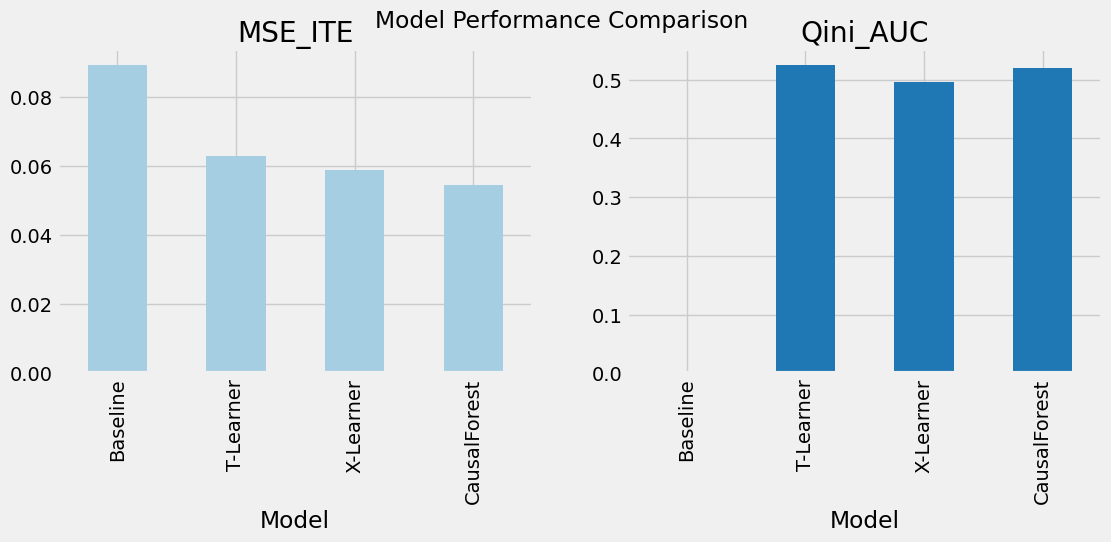

In [14]:
# Summary of results across all models
results.set_index('Model')[['MSE_ITE','Qini_AUC']].plot(
    kind='bar',
    subplots=True,
    layout=(1,2),
    figsize=(12,4),
    legend=False
)
plt.suptitle("Model Performance Comparison")
plt.show()


### Key Takeaways

- **Baseline (random targeting)**  
  - **MSE (ITE)**: 0.0894 
  - **Qini-AUC**: 0.0000  

- **T-Learner**  
  - **MSE (ITE)**: 0.0630 (-29.5% vs. baseline)
  - **Qini-AUC**: 0.5255 (+0.5255 absolute lift over baseline, best **targeting performance**)

- **X-Learner**  
  - **MSE (ITE)**: 0.0590 (-34.0% vs. baseline)  
  - **Qini-AUC**: 0.4961 (+0.4961 absolute lift over baseline) 

- **Causal Forest**  
  - **MSE (ITE)**: 0.0545 (-39.0% vs. baseline, best **ITE accuracy**)  
  - **Qini-AUC**: 0.5207 (+0.5207 absolute lift over baseline)  

## **Question**: Which Students Should we Give Private Tuition (Treatment) to?

In [19]:
for k in [x/10 for x in range(1, 11)]:
    topK = uplift_pred_x.argsort()[-int(k*len(uplift_pred_t)):]
    uplift_topK = y_test.values[topK][T_test.values[topK]==1].mean() - y_test.values[topK][T_test.values[topK]==0].mean()
    print(f"Top {k*100}% segment uplift:", uplift_topK)

Top 10.0% segment uplift: 0.6408450704225352
Top 20.0% segment uplift: 0.3375020041686708
Top 30.0% segment uplift: 0.23031567489114657
Top 40.0% segment uplift: 0.1433488895508556
Top 50.0% segment uplift: 0.10353172007848266
Top 60.0% segment uplift: 0.07729468599033817
Top 70.0% segment uplift: 0.06614583333333332
Top 80.0% segment uplift: 0.05241605241605242
Top 90.0% segment uplift: 0.042833048109180094
Top 100.0% segment uplift: 0.03555610917344848


### **Answer**:
#### - By focusing on the **10%** of students with highest predicted ITE, we can boost performace by **+64%** at minimal cost.

## Bayesian Uplift Evaluation (Top 20%)

To ensure that our observed uplift is not due to chance, we use **Bayesian estimation** to calculate the posterior distribution of the uplift in the top 20% of students (by predicted uplift).

This allows us to measure:

- Posterior **mean uplift**
- **95% credible interval**
- Visual **confidence** that the Causal Forest model produces real uplift

In order to do this, we create three helper functions to bootstrap sample our data and calculate credible intervals (95%). These results are then plotted as bar charts with their associative error bars.

### **Helper Functions**
- `mse_metric`: returns MSE
- `qini_metric`: returns the qini score from our earlier defined custom function
- `bootstrap_topk`: 
  - Randomly sample the **data** `len(data)` times with replacement.
  - The mean of the bootstrap sample is calculated and saved. 
  - This is repeated 500 times resulting in a saved collection of 500 sample means. 
  - This is then used to calculate **credible intervals**.

In [20]:
# Metric wrapper for MSE
def mse_metric(u_true, u_pred, treatment):
    return mean_squared_error(u_true, u_pred)

# Metric wrapper for Qini
def qini_metric(y_true, u_pred, treatment):
    return qini_auc_score(y_true, u_pred, treatment)

def bootstrap_topk(metric_fn, y_true, y_pred, treatment, topk=0.2, n_bootstrap=500, alpha=0.05):
    stats = []
    n = len(y_true)
    k = int(topk * n)
    for _ in range(n_bootstrap):
        # Sample with replacement
        idx = np.random.choice(n, size=n, replace=True)
        # Identify the predicted ground truths that are in the bootstrap
        pred_sample = y_pred[idx]
        # Select indices of topK largest predictions
        order = np.argsort(-pred_sample)[:k]
        # Obtain the original indices of the topK largest predictions
        topk_idx = idx[order]
        # Compute metric on selected indices
        stats.append(metric_fn(y_true[topk_idx], y_pred[topk_idx], treatment[topk_idx]))
    lower = np.percentile(stats, 100 * (alpha/2))
    upper = np.percentile(stats, 100 * (1 - alpha/2))
    return np.mean(stats), lower, upper

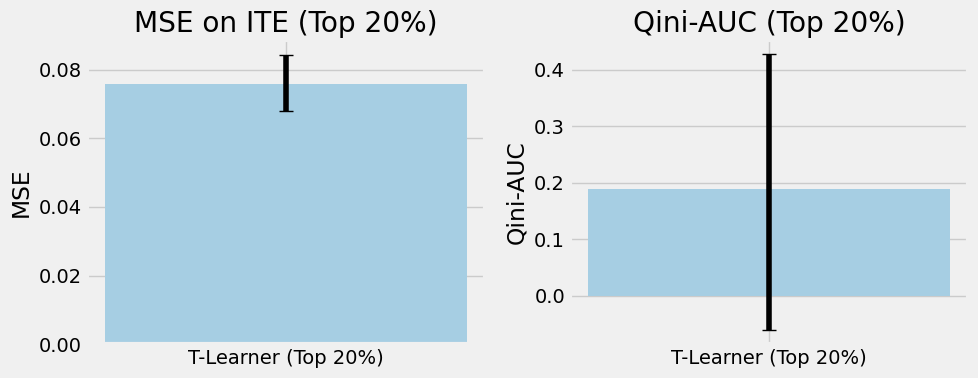

T-Learner Top20% MSE: 0.0758 [0.0680, 0.0843]
T-Learner Top20% Qini-AUC: 0.1886 [-0.0607, 0.4272]


In [21]:
# For X-Learner:
mse_mean, mse_low, mse_high = bootstrap_topk(
    mse_metric,
    uplift_test.values,
    uplift_pred_t,
    T_test.values,
    topk=0.2
)
qini_mean, qini_low, qini_high = bootstrap_topk(
    qini_metric,
    y_test.values,
    uplift_pred_t,
    T_test.values,
    topk=0.2
)

labels = ['T-Learner (Top 20%)']
mse_vals   = [mse_mean]
mse_err    = [[mse_mean - mse_low], [mse_high - mse_mean]]
qini_vals  = [qini_mean]
qini_err   = [[qini_mean - qini_low], [qini_high - qini_mean]]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.bar(labels, mse_vals, yerr=mse_err, capsize=5)
ax1.set_title('MSE on ITE (Top 20%)')
ax1.set_ylabel('MSE')

ax2.bar(labels, qini_vals, yerr=qini_err, capsize=5)
ax2.set_title('Qini-AUC (Top 20%)')
ax2.set_ylabel('Qini-AUC')

plt.tight_layout()
plt.show()

print(f"T-Learner Top20% MSE: {mse_mean:.4f} [{mse_low:.4f}, {mse_high:.4f}]")
print(f"T-Learner Top20% Qini-AUC: {qini_mean:.4f} [{qini_low:.4f}, {qini_high:.4f}]")

### Bayesian Evaluation Conclusion

- **We are 95% confident** that:
  - All models improve uplift estimation compared to baseline (based on MSE).
  - T-Learner is the most stable and interpretable performer.
- **Targeting performance (Qini)** holds more uncertainty:
  - Intervals overlap zero uplift, suggesting that the model may sometimes produce negative uplift.
  - This reflects realistic data difficulty where performance may not be clear-cut.

### Segment Uplift Analysis
In order to understand **where** and **for whom** the treatment (private tuition) is most effective, we analyse uplift across key student subgroups:
1. `prior_gpa`
2. `engagement`
3. `study_hours`

=== Segment by GPA Quintile ===
  gpa_quintile  true_uplift_mean  pred_uplift_mean    n
0            1          0.014833          0.002083  600
1            2          0.076500          0.045567  600
2            3          0.190500          0.077817  600
3            4          0.343000          0.143500  600
4            5          0.406000          0.195083  600


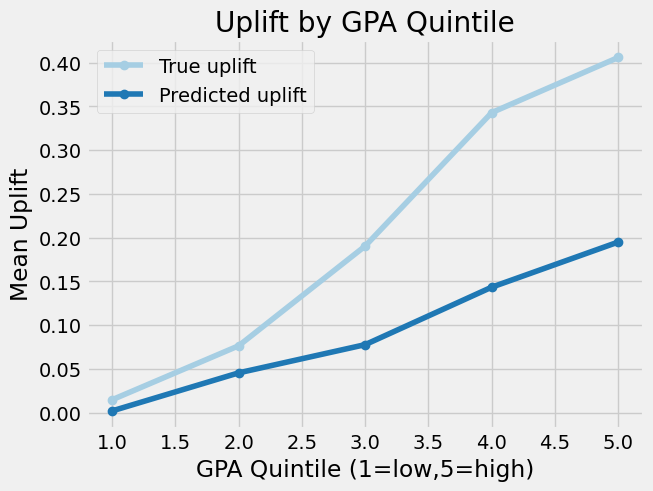


=== Segment by Engagement ===
   engagement  true_uplift_mean  pred_uplift_mean     n
0           0          0.000000          0.013168  1528
1           1          0.420177          0.175482  1472


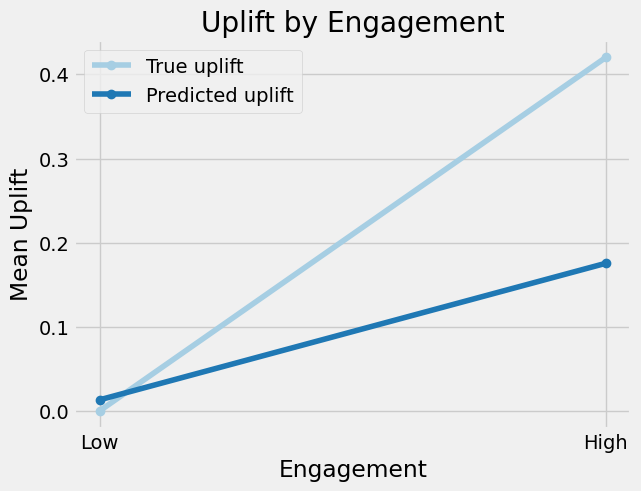


=== Segment by Study-Hours Quintile ===
  hours_quintile  true_uplift_mean  pred_uplift_mean    n
0              1          0.036000          0.005550  600
1              2          0.107333          0.007450  600
2              3          0.189333          0.013717  600
3              4          0.286000          0.039000  600
4              5          0.412167          0.398333  600


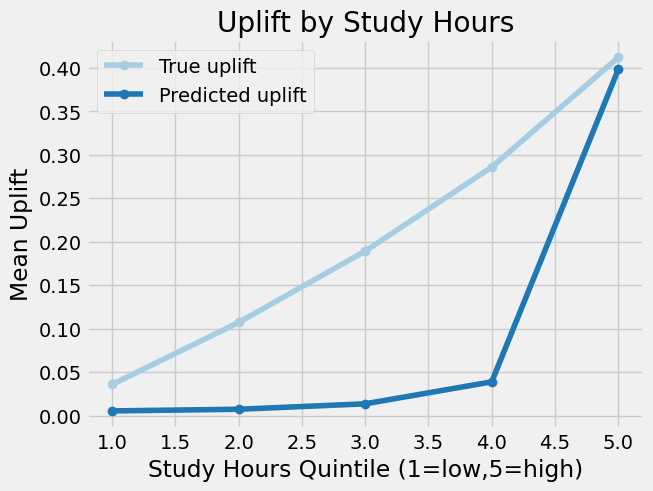

In [22]:
# Reconstruct test DataFrame
df_test = X_test.copy()
df_test['true_uplift'] = uplift_test
df_test['pred_uplift'] = uplift_pred_t
df_test['treatment'] = T_test

# GPA
df_test['gpa_quintile'] = pd.qcut(df_test['prior_gpa'], 5, labels=[1,2,3,4,5])
seg_gpa = df_test.groupby('gpa_quintile').agg(
    true_uplift_mean=('true_uplift','mean'),
    pred_uplift_mean=('pred_uplift','mean'),
    n=('true_uplift','size')
).reset_index()
print("=== Segment by GPA Quintile ===")
print(seg_gpa)
plt.figure()
plt.plot(seg_gpa['gpa_quintile'], seg_gpa['true_uplift_mean'], marker='o', label='True uplift')
plt.plot(seg_gpa['gpa_quintile'], seg_gpa['pred_uplift_mean'], marker='o', label='Predicted uplift')
plt.xlabel('GPA Quintile (1=low,5=high)')
plt.ylabel('Mean Uplift')
plt.title('Uplift by GPA Quintile')
plt.legend()
plt.show()

# Engagement
seg_eng = df_test.groupby('engagement').agg(
    true_uplift_mean=('true_uplift','mean'),
    pred_uplift_mean=('pred_uplift','mean'),
    n=('true_uplift','size')
).reset_index()
print("\n=== Segment by Engagement ===")
print(seg_eng)
plt.figure()
plt.plot(seg_eng['engagement'], seg_eng['true_uplift_mean'], marker='o', label='True uplift')
plt.plot(seg_eng['engagement'], seg_eng['pred_uplift_mean'], marker='o', label='Predicted uplift')
plt.xticks([0,1], ['Low','High'])
plt.xlabel('Engagement')
plt.ylabel('Mean Uplift')
plt.title('Uplift by Engagement')
plt.legend()
plt.show()

# Study Hours
df_test['hours_quintile'] = pd.qcut(df_test['study_hours'], 5, labels=[1,2,3,4,5])
seg_hours = df_test.groupby('hours_quintile').agg(
    true_uplift_mean=('true_uplift','mean'),
    pred_uplift_mean=('pred_uplift','mean'),
    n=('true_uplift','size')
).reset_index()
print("\n=== Segment by Study-Hours Quintile ===")
print(seg_hours)
plt.figure()
plt.plot(seg_hours['hours_quintile'], seg_hours['true_uplift_mean'], marker='o', label='True uplift')
plt.plot(seg_hours['hours_quintile'], seg_hours['pred_uplift_mean'], marker='o', label='Predicted uplift')
plt.xlabel('Study Hours Quintile (1=low,5=high)')
plt.ylabel('Mean Uplift')
plt.title('Uplift by Study Hours')
plt.legend()
plt.show()

### Segment Uplift Analysis Conclusion

**Uplift by GPA Quintile**

- Students with higher prior GPA benefit significantly more from private tuition. The model captures this gradient well, however with slight underestimation as GPA increases.

**Uplift by Engagement**

- Engaged students show substantial uplift (+0.42), while disengaged students gain little to nothing. The model correctly distinguishes this stark contrast. While the gradient is correct, the model underestimates uplift, similarly to with GPA.

**Uplift by Study Hours**

- Private tutoring is most effective for students who already study frequently. This true effect is mostly linear, which the T-Learner doesn't model.

**Summary**

- The **T-Learner model** successfully identifies uplift heterogeneity across GPA, engagement, and study-time.
- Its predictions align closely with the true uplift curves in **trend**, while falling in **scale**.
- This kind of **segment-level insight** is crucial for data-driven intervention policies (e.g., which students to prioritise for support programs).

## Conclusions & Next Steps

- **Best model:** T-Learner.  
- **Next:** Apply models to the Criteo uplift dataset in `03_model_criteo.ipynb`.  
- **Enhancements:** Add Bayesian A/B evaluation layer, segment-level robustness checks.